# Example notebook 2
## Perform experiments for and evaluate all endpoints

This notebook is part of the supporting information of the manuscript entitled *Assessing the Calibration in Toxicological in Vitro Models with Conformal Prediction*.
* A. Morger, F. Svensson, S. Arvidsson McShane, N. Gauraha, U. Norinder, O. Spjuth and A. Volkamer.
* Last updated in January 2021.

## Content


This notebook shows how the experiments for the CPTox21 manuscript *Assessing the Calibration in Toxicological in Vitro Models with Conformal Prediction* are run for multiple endpoints.

* It can be used to train aggregated conformal predictors (ACP) on the individual Tox21Train datasets. 
* The predictions of Tox21Score can be compared in different experiments (as introduced in the manuscript)
    * With and without updated calibration sets
    * With updating the complete training set. 
* The evaluation over all endpoints in the form of boxplots is provided.
* Note that you can either run all experiments and evaluate them or load the results from the manuscript and illustrate the saved results. Therefore, change the `run_experiment` parameter in `input cell 6`.

For a general introduction on conformal prediction (CP) and calibration plots, we refer to the manuscript.

### Table of contents
1. [Preparation](#preparation) <br>
    1.1. [Import libraries and modules](#import-libraries-and-modules)<br>
    1.2. [Define paths and parameters](#define-paths-parameters)<br>
2. [Conformal prediction experiments](#cp-experiments)<br>
    2.1. [Build conformal predictors](#build-cp)<br>
    2.2. [Perform experiments for all endpoints](#perform-exp)<br>
3. [Evaluate conformal predictions](#evaluate-cp)<br>
    3.1. [Calibration and efficiency plots](#cal-plots)<br>
    3.2. [Root-mean-square deviations from the diagonal (RMSD)](#rmsd)<br>
    3.3. [Boxplots](#boxplots)<br>
    3.4. [Line plots](#line-plots)<br>

## 1. Preparation <a id='preparation'></a>

### 1.1. Import libraries and modules <a id='import-libraries-and-modules'></a>

In [1]:
import os
import numpy as np
import math
from pathlib import Path

In [2]:
import pandas as pd
from sklearn.svm import SVC
from nonconformist.nc import NcFactory, MarginErrFunc
import matplotlib.pyplot as plt

In [3]:
from cptox21 import (
    define_path, load_signatures_files, InductiveConformalPredictor,
    CPTox21AggregatedConformalPredictor, AggregatedConformalPredictor, 
    StratifiedRatioSampler, CrossValidationSampler, KnownIndicesSampler,
    CPTox21CrossValidator, CPTox21TrainUpdateCrossValidator,
    calculate_rmsd_from_df
)
from helper_functions import (load_data, cross_validate_compare_calibration_sets, 
                              cross_validate_with_updated_training_set, boxplot_rmsd,
                             draw_calibration_plot_all_endpoints)

In [4]:
import warnings
warnings.simplefilter("ignore")

### 1.2. Define paths and parameters <a id='define-paths-parameters'></a>

In [5]:
# Paths
HERE = Path(_dh[-1])
DATA = HERE / "../data"
data_signatures_path = DATA / "data_signatures/"
data_statistics_path = DATA / "data_statistics/"  # Use data from this directory

In [6]:
# Define if model fitting and predictions are required (set to True) or if data 
# are already available (set to False).
run_experiment = True  # False
# If we do a test run (test_run is True, we can train with a much smaller training 
# set (n = 500), which will result in faster calculations).
test_run = False
# Set the random seed for deterministic results
set_random_state = None 

In [7]:
# Parameters
n_folds_acp = 20
n_cv = 5

In [8]:
endpoints = [
    'NR_AhR', 'NR_AR', 'NR_AR_LBD', 'NR_Aromatase', 'NR_ER', 'NR_ER_LBD', 'NR_PPAR_gamma', 
    'SR_ARE', 'SR_ATAD5', 'SR_HSE', 'SR_MMP', 'SR_p53', 
]

## 2. Conformal prediction experiments <a id='cp-experiments'></a>

### 2.1. Build conformal predictors <a id='build-cp'></a>

In [9]:
# Build ICP (inductive conformal predictor)
clf = SVC(
    kernel = 'rbf', C = 50, gamma = 0.002, probability = True, random_state = set_random_state
)  # ML classifier
error_function = MarginErrFunc()  # Error function
normaliser_model = None  # Normaliser model
nc = NcFactory.create_nc(clf, err_func = error_function)  # Nonconformity scoreer
icp = InductiveConformalPredictor(
    nc_function = nc, condition = (lambda instance: instance[1])
)  # Mondrian as (default) condition)

In [10]:
# Build ACP (aggregated conformal predictor, to perform the experiments with the
# different calibration sets.)
acp = CPTox21AggregatedConformalPredictor(
        predictor = icp, sampler = StratifiedRatioSampler(n_folds = n_folds_acp, random_state = set_random_state),
        aggregation_func = np.median
    )

In [11]:
# Build ACP (accepts only one calibration set, used for the experiment with the
# updated training set)
train_update_acp = AggregatedConformalPredictor(
        predictor = icp, sampler = StratifiedRatioSampler(n_folds = n_folds_acp, random_state = set_random_state),
        aggregation_func = np.median
    )

### 2.2. Perform experiments for all endpoints <a id='perform-exp'></a>

In [13]:
evaluation_dfs = {"1_internal_cv": [],
                  "2_pred_score": [],
                  "4_train_update": [],
                  "5_cal_update": [], 
                  "6_cal_update2": []
                  }

for endpoint in endpoints:
    print(endpoint)
    if run_experiment: # If we want to make calculations for all set-ups
        
        # Load data (signatures and activity labels per endpoint and 
        # Tox21 dataset (Toxtrain, Tox21test, Tox21score))
        X_train, y_train, X_test, y_test, X_score, y_score = load_data(
            endpoint, signatures_path = data_signatures_path, short_train = True
        )
        
        if test_run:
            X_train = X_train[:500]
            y_train = y_train[:500]
        
        # Cross-validate with different calibration sets
        cptox21_cross_validator = cross_validate_compare_calibration_sets(
            endpoint, acp, X_train, y_train, X_test, y_test, X_score, y_score, n_cv = n_cv, 
            random_state = set_random_state
        )
        
        # Store dataframes with evaluation measures per set-up
        
        # Experiment 1
        evaluation_dfs["1_internal_cv"].append(
            getattr(
                cptox21_cross_validator, "averaged_evaluation_df_cv"
            )  
        )
        # Experiment 2
        evaluation_dfs["2_pred_score"].append(
            getattr(
                cptox21_cross_validator, "averaged_evaluation_df_pred_score"
            ) 
        )
        # Experiment 5
        evaluation_dfs["5_cal_update"].append(
            getattr(
                cptox21_cross_validator, "averaged_evaluation_df_cal_update"
            ) 
        )
        # Experiment 6
        evaluation_dfs["6_cal_update2"].append(
            getattr(
                cptox21_cross_validator, "averaged_evaluation_df_cal_update2"
            )
        )
                                
        # Save data
        for strategy in ["cv", "pred_score", "pred_test", "cal_update", "cal_update2"]:
            (getattr(
                cptox21_cross_validator, f"averaged_evaluation_df_{strategy}"
            )).to_csv(os.path.join(data_statistics_path, f"{endpoint}_averaged_eval_df_{strategy}.csv")
            )
        
        # Get train and test indices from cptox21_cross_validator,
        # to use same indices for train_update
        train_index, test_index = cptox21_cross_validator.train_indices, cptox21_cross_validator.test_indices
        known_indices_sampler = KnownIndicesSampler(
            known_train = train_index, known_test = test_index
        )

        # Cross-validate with updated training set
        train_update_cross_validator = cross_validate_with_updated_training_set(
            endpoint, train_update_acp, X_train, y_train, X_test, y_test, 
            X_score, y_score, known_indices_sampler
        )
        
        # Experiment 4
        evaluation_dfs["4_train_update"].append(
            getattr(
                train_update_cross_validator, "averaged_evaluation_df_pred_score"
            )     
        )

        for strategy in ["cv", "pred_score"]:
            (
                getattr(
                    train_update_cross_validator, f"averaged_evaluation_df_{strategy}"
            )
            ).to_csv(
                os.path.join(
                    data_statistics_path,
                    f"{endpoint}_averaged_eval_df_{strategy}_train_update.csv"
                )
            )
            
        
    else: # If results are already available and dataframes can be loaded directly
        # Experiment 1
        evaluation_dfs["1_internal_cv"].append(
            pd.read_csv(
                os.path.join(data_statistics_path, f"{endpoint}_averaged_eval_df_cv.csv")
            )
        )
        # Experiment 2
        evaluation_dfs["2_pred_score"].append(
            pd.read_csv(
                os.path.join(data_statistics_path, f"{endpoint}_averaged_eval_df_pred_score.csv")
            )
        )
        # Experiment 4
        evaluation_dfs["4_train_update"].append(
            pd.read_csv(
                os.path.join(data_statistics_path, f"{endpoint}_averaged_eval_df_pred_score_train_update.csv")
            )
        )
        # Experiment 5
        evaluation_dfs["5_cal_update"].append(
            pd.read_csv(
                os.path.join(data_statistics_path, f"{endpoint}_averaged_eval_df_cal_update.csv")
            )
        )
        # Experiment 6
        evaluation_dfs["6_cal_update2"].append(
            pd.read_csv(
                os.path.join(data_statistics_path, f"{endpoint}_averaged_eval_df_cal_update2.csv")
                        )
                    )        

NR_AhR
NR_AR
NR_AR_LBD
NR_Aromatase
NR_ER
NR_ER_LBD
NR_PPAR_gamma
SR_ARE
SR_ATAD5
SR_HSE
SR_MMP
SR_p53


## 3. Evaluate conformal predictions <a id='evaluate-cp'></a>

### 3.1. Calibration and efficiency plots <a id='cal-plots'></a>
Using the function `draw_calibration_plot_all_endpoints`, one could see the calibration and efficiency plots (CEPs) for all 12 endpoints. Change `strategy` to `cv`, `pred_score`, `pred_test`, `cal_update`, `train_update` etc. depending, on the results of which experiment you would like to visualise.

(<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/cptox21_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <matplotlib.legend.Legend at 0x7f4dc799bb80>)

<Figure size 432x288 with 0 Axes>

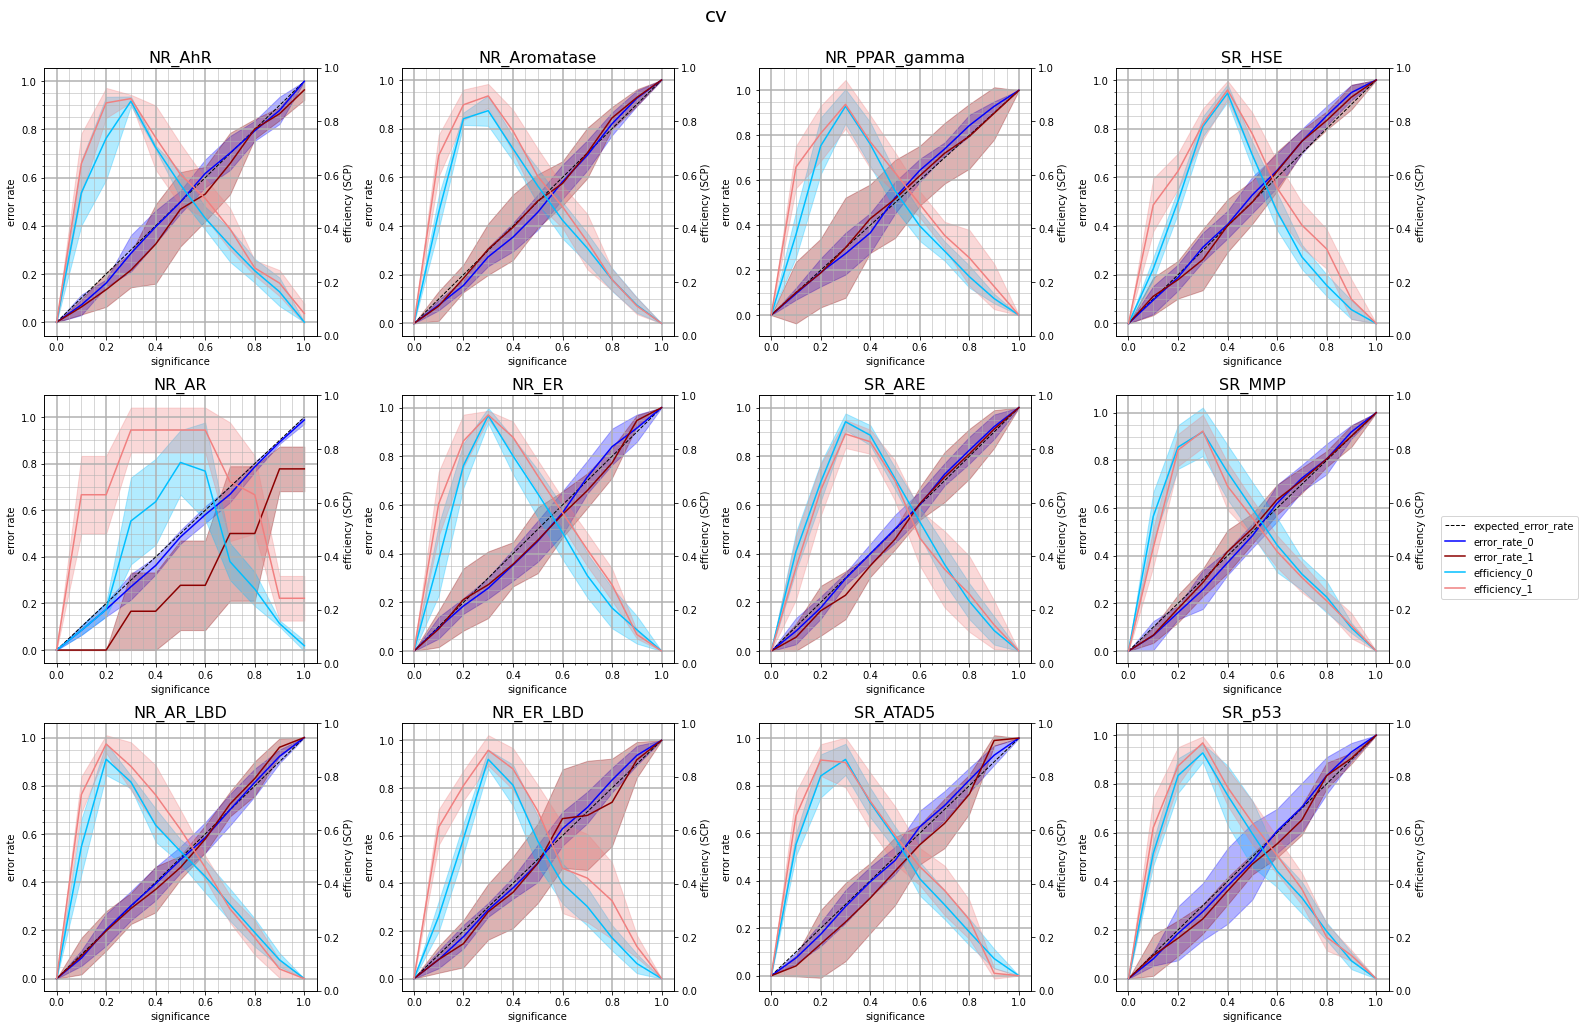

In [14]:
draw_calibration_plot_all_endpoints(endpoints = endpoints, strategy = 'cv', path = data_statistics_path)

### 3.2.  Root-mean-square deviations from the diagonal (RMSD) <a id='rmsd'></a>

#### Calculate RMSD's for all endpoints over all strategies

To have a value to compare the calibration (validity) over all experiments, we calculate the RMSD of the observed error rate to the expected error rate (for 10 significance levels).

In [16]:
rmsds = {}
for k, v in evaluation_dfs.items():
    rmsds[k] = []
    for df in v:        
        rmsd = calculate_rmsd_from_df(df)
        rmsds[k].append(rmsd)

pd.DataFrame(rmsds, index = endpoints)

,1_internal_cv,2_pred_score,4_train_update,5_cal_update,6_cal_update2
NR_AhR,0.021,0.161,0.041,0.035,0.021
NR_AR,0.027,0.159,0.108,0.044,0.016
NR_AR_LBD,0.013,0.242,0.146,0.058,0.017
NR_Aromatase,0.023,0.090,0.035,0.080,0.009
NR_ER,0.027,0.123,0.077,0.034,0.029
NR_ER_LBD,0.022,0.193,0.126,0.118,0.023
NR_PPAR_gamma,0.024,0.130,0.084,0.070,0.014
SR_ARE,0.018,0.055,0.065,0.067,0.018
SR_ATAD5,0.022,0.247,0.130,0.018,0.015
SR_HSE,0.028,0.154,0.117,0.106,0.019


### 3.3. Boxplots <a id='boxplots'></a>

Given the RMSD's per endpoint, we can draw a boxplot over the RMSD values for all endpoints. This gives us a nice overview on how the RMSD's change among the different CP set-ups.

In [17]:
strategies = ["1_internal_cv", 
              "2_pred_score",
              "4_train_update",
              "5_cal_update", 
              "6_cal_update2"]

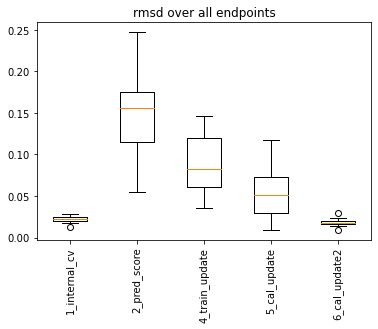

In [18]:
boxplot_rmsd(rmsds, "rmsd", strategies)

The above boxplots nicely illustrate how the calibration changes depending on the conformal prediction setup. Within the crossvalidation on Tox21Train, the models are well calibrated while the calibration is poorer for the prediction of the Tox21Score data. The first strategy, where the training set is updated with more recent (Tox21Test) data (pred_score_train_update), improves the calibration to some extent. A better improvement can be seen when only the calibration set is exchanged with Tox21Test (*5_cal_update*). The goodness of the calibration is mainly dependant on the data drifts between the calibration and prediction set. This is nicely illustrated by the well calibrated models where the calibration set is exchanged by a randomly stratified selected part of Tox21Score and the other part of Tox21Score is predicted (*6_cal_update2*), presuming that the calibration and prediction set stem from the same distribution.

### 3.4. Line plots <a id='line-plots'></a>

To see how the RMSD's change for the individual endpoints and detect possible "outlier endpoints", we can look at the following line plots.

Note, that these plots were initially used for internal investigation, e.g. which endpoints should be selected as example in the manuscript.

In [19]:
def line_plot_rmsd(rmsds, strategies, colours = None, markers = None, figsize = (5, 10)):
    plt.clf()
    fig = plt.figure(figsize = figsize)
    if colours is None:
        colours = ['navy', 'royalblue', 'blueviolet', 'plum', 'mediumvioletred', 'red', 'coral', 'gold', 'yellowgreen', 'green', 'paleturquoise', 'slategrey']
    if markers is None:
        markers = ['3', '<', '>', 'x', 's', '+', 'd', 'h', '*', '1', 'o', 'D']
    for i, ep in enumerate(endpoints):
    
        plt.plot(strategies, [rmsds[s][i] for s in strategies], color = colours[i], linewidth = 0.5)
        plt.scatter(strategies, [rmsds[s][i] for s in strategies], label = ep, color = colours[i], marker = markers[i], s = 50)
        plt.xticks(rotation = 'vertical')
        plt.legend(endpoints, loc = 'upper right', bbox_to_anchor = (1.5, 1))
    

<Figure size 432x288 with 0 Axes>

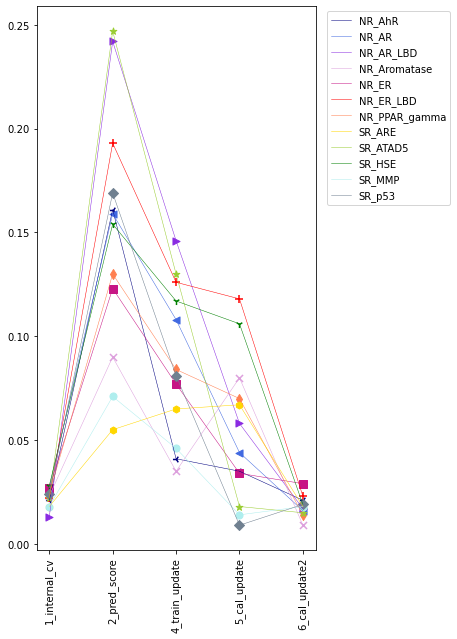

In [20]:
line_plot_rmsd(rmsds, strategies)